# Regression
We will try to predict the percentage of votes won by Bill Clinton in the 1992
election.

### Read the data

In [1]:
import pandas as pd

# read in the .dat file with variable-length spaces as the delimiter
df = pd.read_table('clinton1.dat', delimiter='  \s+', header=None, names=['county', 'percentVoting', 'age', 'savings', 'income', 'poverty', 'percentVeterans', 'percentFemale', 'popDensity', 'percentNursing', 'crimeIndex'])

df.head()

C:\Users\Jack\AppData\Local\Temp\ipykernel_18172\1303639836.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_table('clinton1.dat', delimiter='  \s+', header=None, names=['county', 'percentVoting', 'age', 'savings', 'income', 'poverty', 'percentVeterans', 'percentFemale', 'popDensity', 'percentNursing', 'crimeIndex'])


,county,percentVoting,age,savings,income,poverty,percentVeterans,percentFemale,popDensity,percentNursing,crimeIndex
0,"Autauga, AL",30.92,31.7,57623,15768,15.2,10.74,51.41,60.4,2.36,457
1,"Baldwin, AL",26.24,35.5,84935,16954,13.6,9.73,51.34,66.5,5.40,282
2,"Barbour, AL",46.36,32.8,83656,15532,25.0,8.82,53.03,28.8,7.02,47
3,"Blount, AL",32.92,34.5,61249,14820,15.0,9.67,51.15,62.4,2.36,185
4,"Bullock, AL",67.67,31.7,75725,11120,33.0,7.08,50.76,17.6,2.91,141


### Predict percentVoting on all regressors.

In [2]:
import statsmodels.api as sm
from patsy import dmatrices

In [3]:
df['county'].nunique()/len(df)

0.9992603550295858

In [4]:
# Here county is not included because it is almost unique for each row.
# Including it won't help us detect overall patterns using regression, and it can cause overfitting.
y, X = dmatrices('percentVoting ~ age + savings + income + poverty + percentVeterans + percentFemale + popDensity + percentNursing + crimeIndex', data=df, return_type='dataframe')

In [5]:
# Set up the model
model = sm.OLS(y, X)
# Fit model (find the intercept and slope)      
result = model.fit()     
# Print the summary statistics of the model 
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          percentVoting   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     145.4
Date:                Mon, 03 Apr 2023   Prob (F-statistic):          4.12e-224
Time:                        20:34:31   Log-Likelihood:                -9576.0
No. Observations:                2704   AIC:                         1.917e+04
Df Residuals:                    2694   BIC:                         1.923e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -38.3094      5.818     

In [6]:
print(result.pvalues.sort_values(ascending=False))

age                 2.386186e-01
crimeIndex          1.419496e-01
income              1.761381e-02
percentNursing      5.246414e-03
percentVeterans     3.852591e-04
savings             4.859660e-10
Intercept           5.457367e-11
popDensity          8.177372e-22
percentFemale       4.425751e-23
poverty            9.526970e-100
dtype: float64


<b>Findings:</b> we can see age and crimeIndex are the two regressors with the worst p-values. 

### A formula-creating function
We create a function called `formula` that
* takes a list of regressors as input, and
* outputs the formula for regressing `percentVoting` on these regressors.

In [7]:
def formula(regressors):
    return 'percentVoting ~ ' + ' + '.join(regressors)

In [8]:
formula(['age', 'savings'])

'percentVoting ~ age + savings'

### R-squared computation function.
We create a function called `rsquared` that with the following properties:
* **Input:** a list of regressors (e.g., `['age', 'savings']`),
* **Output:** the R-squared of a regression of `percentVoting` with respect to the list of regressors.

In [9]:
def rsquared(regressors):
    y, X = dmatrices(formula(regressors), data=df, return_type='dataframe')
    model = sm.OLS(y, X)
    result = model.fit()
    return result.rsquared

rsquared(['age'])

0.0033799834005024953

### Find the next best regressor.
We create a function called `best_next_regressor` with the following properties:
* **Inputs:**
    * a list of regressors (called `current_regressors`), and
    * the list of all possible regressors (called `all_regressors`).
* **What it does:** For every regressor `x` from the `all_regressors` list that, calculate the R-square if you regressed `percentVoting` using `x` AND all the regressors in `current_regressors`.
* **Output:** Return the regressor `x` that gives the highest R-square value above. Also, return this R-square value.

In [10]:
def best_next_regressor(current_regressors, all_regressors):
    best_r2 = 0
    best_regressor = None
    for regressor in all_regressors:
        if regressor not in current_regressors:
            r2 = rsquared(current_regressors + [regressor])
            if r2 > best_r2:
                best_r2 = r2
                best_regressor = regressor
    return best_regressor, best_r2

all_regressors = ['age', 'savings', 'income', 'poverty', 'percentVeterans', 'percentFemale', 'popDensity', 'percentNursing', 'crimeIndex']
best_next_regressor([], all_regressors)

('poverty', 0.2510385196163196)

### Feature Selection: pick the k best regressors.
We create a function called `best_regressors` that has the following properties:
* **Inputs:**
    * `k`, which is the number of regressors we want (e.g., `k=3`), and
    * `all_regressors`, which again is the list of all possible regressors.
* **What it does:** The function `best_regressors` should compute the best `k` regressors by picking them one at a time using the `best_next_regressor` function from Q5.
* **Outputs:** The function should return a tuple of the following items:
    * a list of the best regressors, in the order in which they were picked, and
    * the corresponding R-square values.

In [11]:
def best_regressors(k, all_regressors):
    current_regressors = []
    r2s = []
    for i in range(k):
        best_regressor, best_r2 = best_next_regressor(current_regressors, all_regressors)
        current_regressors.append(best_regressor)
        r2s.append(best_r2)
    return current_regressors, r2s

all_regressors = ['age', 'savings', 'income', 'poverty', 'percentVeterans', 'percentFemale', 'popDensity', 'percentNursing', 'crimeIndex']
best_regressors(3, all_regressors)

(['poverty', 'popDensity', 'percentFemale'],
 [0.2510385196163196, 0.2858298022910579, 0.30914506632485783])

We run `best_regressors` to output all available regressors in sequence.

We are implementing forward selection here.

In [12]:
all_regressors = ['age', 'savings', 'income', 'poverty', 'percentVeterans', 'percentFemale', 'popDensity', 'percentNursing', 'crimeIndex']
best_regressors(9, all_regressors)

(['poverty',
  'popDensity',
  'percentFemale',
  'savings',
  'percentVeterans',
  'percentNursing',
  'income',
  'crimeIndex',
  'age'],
 [0.2510385196163196,
  0.2858298022910579,
  0.30914506632485783,
  0.31924118502370513,
  0.32299256887291694,
  0.3248512713869368,
  0.32582492389958884,
  0.32655325570492566,
  0.32690038725174053])

### Plot the R-squared values as regressors are added in the best order.

Text(0.5, 1.0, 'R-squared vs. Regressors')

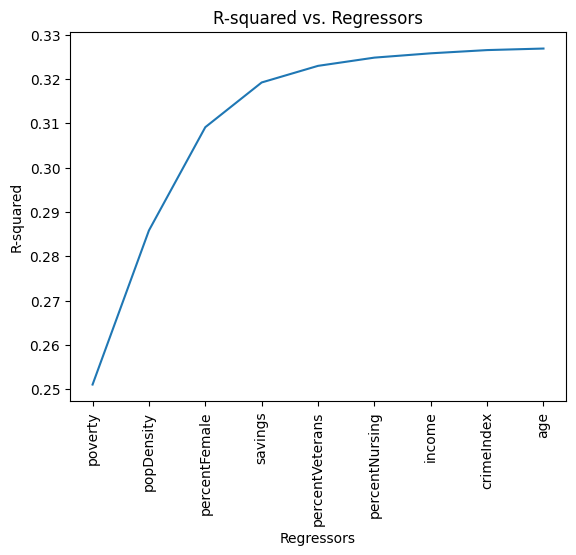

In [13]:
import matplotlib.pyplot as plt

plt.plot(best_regressors(9, all_regressors)[0], best_regressors(9, all_regressors)[1])

# Make the x axis labels readable
plt.xticks(rotation=90)

plt.ylabel('R-squared')
plt.xlabel('Regressors')
plt.title('R-squared vs. Regressors')

---
# K-Nearest Neighbors Classification
We will work with the same dataset as above.

### Create a classification target.
We attached a new column, called `target` to the DataFrame, whose value for each row is either 1 (if `percentVoting` is at least 40.0), or 0 (if `percentVoting` is less than 40.0).

In [14]:
df['target'] = df['percentVoting'].apply(lambda x: 1 if x >= 40.0 else 0)

df.head()

,county,percentVoting,age,savings,income,poverty,percentVeterans,percentFemale,popDensity,percentNursing,crimeIndex,target
0,"Autauga, AL",30.92,31.7,57623,15768,15.2,10.74,51.41,60.4,2.36,457,0
1,"Baldwin, AL",26.24,35.5,84935,16954,13.6,9.73,51.34,66.5,5.40,282,0
2,"Barbour, AL",46.36,32.8,83656,15532,25.0,8.82,53.03,28.8,7.02,47,1
3,"Blount, AL",32.92,34.5,61249,14820,15.0,9.67,51.15,62.4,2.36,185,0
4,"Bullock, AL",67.67,31.7,75725,11120,33.0,7.08,50.76,17.6,2.91,141,1


### Create training and test sets.
* We create a design matrices for predicting the `target` using just the two most predictive features: `poverty` and `popdensity`.
* We then split this into design matrices for training and testing datasets, with 70% data being used for training, and 30% for testing.

In [15]:
from sklearn.model_selection import train_test_split
Y, X = dmatrices('target ~ poverty + popDensity', data=df, return_type='dataframe')
y = Y['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Accuracy of classification.
* We use a K-nearest neighbors classifier to predict the target using the two given features
* We will look at the performances for 1, 3, 5, 10, 20, 50, 100, and 1000 nearest neighbors

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

for k in [1, 3, 5, 10, 20, 50, 100, 1000]:
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform', p=2)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    print('k =', k, 'train accuracy =', accuracy_score(y_train, y_pred))
    y_pred = knn.predict(X_test)
    print('k =', k, 'test accuracy =', accuracy_score(y_test, y_pred))

k = 1 train accuracy = 0.9968287526427061
k = 1 test accuracy = 0.6022167487684729
k = 3 train accuracy = 0.7854122621564482
k = 3 test accuracy = 0.6391625615763546
k = 5 train accuracy = 0.7521141649048626
k = 5 test accuracy = 0.6576354679802956
k = 10 train accuracy = 0.7087737843551797
k = 10 test accuracy = 0.6637931034482759
k = 20 train accuracy = 0.6966173361522199
k = 20 test accuracy = 0.6884236453201971
k = 50 train accuracy = 0.662262156448203
k = 50 test accuracy = 0.7007389162561576
k = 100 train accuracy = 0.6643763213530656
k = 100 test accuracy = 0.6995073891625616
k = 1000 train accuracy = 0.5819238900634249
k = 1000 test accuracy = 0.5689655172413793


<b>Findings:</b> we can see k = 1000 leads to the highest test accuracy.

### Plots and reasons.
A scatter plot of `popdensity` versus `poverty`, and color the points according to the `target`.

What types of counties voted for Bill Clinton?

Text(0.5, 1.0, 'Population Density vs. Poverty')

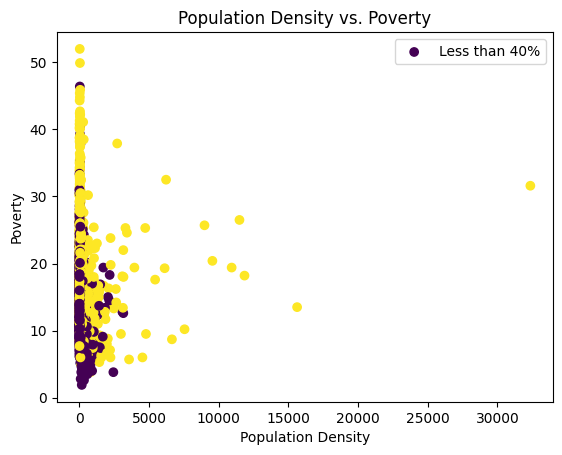

In [17]:
plt.scatter(df['popDensity'], df['poverty'], c=df['target'])

plt.legend(['Less than 40%', 'More than 40%'])
plt.xlabel('Population Density')
plt.ylabel('Poverty')
plt.title('Population Density vs. Poverty')


In [18]:
# For the county with max popDensity more than 40% voted for Clinton, so indeed, yellow points are when target = 1, and purple points are when target = 0.
df[df['popDensity'] == max(df['popDensity'])]

,county,percentVoting,age,savings,income,poverty,percentVeterans,percentFemale,popDensity,percentNursing,crimeIndex,target
1601,"Kings, NY",70.7,32.3,100509,19009,31.6,8.11,53.19,32360.3,4.13,2792,1


<b>Findings:</b> from the graph we can see counties with high population density and poverty rate usually are more likely (more than 40%) to vote for Clinton in 1992.